In [1]:
#Fgure 1 - Appendix Bins and Balls Alternative Benchmark

In [2]:
#Calibration 1
#Each firm receives a number of balls in proportion to it's sales at the destination. The balls are distributed across HS-category grid. 
# The probability that a ball lands in a country-HS group cell is given by the product of share of sales that belong to 
# an HS-category 
# The final plot shows the distribution of the number of products in the data and predicted by the alternative benchmark

In [3]:
#Download and install the joblib library from the Python Package Index (PyPI)

In [4]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Imports the NumPy library and aliases it as 'np'.
import numpy as np

# Imports the pandas library and aliases it as 'pd'. 
import pandas as pd

# Imports the 'Parallel' and 'delayed' functions from the joblib library. Joblib is a set of tools to provide 
# lightweight pipelining in Python. 'Parallel' is used to execute functions in parallel, while 'delayed' is a 
# simple decorator to capture the arguments of a function. This setup is useful for parallel processing.
from joblib import Parallel, delayed

# Imports the pyplot interface of the matplotlib library as 'plt'. 
import matplotlib.pyplot as plt

#to check the number of cores availiable on the PC download 
from multiprocessing import cpu_count


In [6]:
shipment_size= 51140.41
#84608.4  average shipment size between the US and China
#47542.06   average shipment size overall
#51140.41  average shipment size for shipments >250

In [7]:
# Load the files with the number of balls per firm, share of each HS code in total sales, HScodes

In [8]:
# Sales in each HS category 

# Define the path to the CSV file containing sales data using a relative path.
path_shares_values = r'..\Data-python\HS_shares.csv'  
# Load the sales shares data from the specified path. The data is expected to be tab-delimited.
hs_shares = np.genfromtxt(path_shares_values, delimiter='\t')

# Define the path to the CSV file containing HS codes using a relative path.
path_codes_values = r'..\Data-python\HS_codes.csv'
# Load the HS codes data from the specified path. The data is also expected to be tab-delimited.
Hscodes = np.genfromtxt(path_codes_values, delimiter='\t')

# Convert the loaded HS shares data from a NumPy array to a Python list for easier manipulation.
hs_shares = hs_shares.tolist()
# Reshape the HS codes data into a column vector to ensure it has a consistent structure for analysis.
# The '-1' in reshape(-1, 1) indicates that the number of rows should be inferred from the length of the array, 
# making it a single column with as many rows as necessary.
Hscodes = Hscodes.reshape(-1, 1)

# Calculate the total sum sales across all HS categories 
total_sum = sum(hs_shares)
# Divide sales in an HS-category as 
hs_shares = [share / total_sum for share in hs_shares]

# Print the sum of all elements in the normalized hs_shares list to verify that it equals 1 after normalization.
print("The sum of all elements in the hs_shares is:", sum(hs_shares))


The sum of all elements in the hs_shares is: 0.9999999999999996


In [9]:
# Load the Balls data from a CSV file located in a relative path '../Data/Balls_All.csv'.
# The data is expected to be tab-delimited ('\t'), which is specified by the delimiter parameter.
Balls = np.genfromtxt(r'..\Data-python\Balls_US.csv', delimiter='\t')

# Normalize the loaded Balls data by dividing firm sales by 'shipment_size'.
Balls = Balls / shipment_size

# Round up each value in the Balls array to the nearest whole number.
# This is done to ensure the count of balls is represented as whole numbers,
# as partial balls are not meaningful in this context.
Balls = np.ceil(Balls)

In [10]:
#Load number of products per firm data for the US
path_nprod_data=r'..\Data-python\nprod_data.csv'
nprod_data = np.genfromtxt(path_nprod_data, delimiter='\t')

In [11]:
#Set up a function to allocate a ball across HS-categories

In [12]:
#This function simulates the allocation of balls across different HScodes (defined by hs_shares probabilities) and 
#associates each allocation with an identifier (i). The final output is a matrix where each row contains the identifier, 
#the HS code, and the number of balls allocated to that HS code, based on the simulated multinomial distribution.

def process_ball(i, ball):
    
    product = np.random.multinomial(ball, hs_shares, size=1)
    id = i * np.ones(len(hs_shares))
    id = id.reshape(-1, 1)
    stacked_matrix = np.hstack((id, Hscodes))
    iter = np.array(product[0])
    iter = iter.reshape(-1, 1)
    return np.hstack((stacked_matrix, iter))

In [13]:
# Use joblib to parallelize the loop to evalutate process_ball function for every element in Balls

#num_cores = cpu_count()-1  # use all available cores

# Adjust the number of cores to stay within Windows' limits.Here we ensure not to exceed 60 (to leave some room for other
#processes and avoid hitting the 64 limit) Note that this machine has 64 cores, in case your machine has fewer cores, 
#the maximum number of cores availiable to joblib maybe smaller
num_cores = min(cpu_count() - 1, 60)

results = Parallel(n_jobs=num_cores)(delayed(process_ball)(i, ball) for i, ball in enumerate(Balls, 1))

# Combine the results into a matrix with 
matrix = np.vstack(results)


In [14]:
# Create a DataFrame from 'matrix' with specific column names for readability.
df = pd.DataFrame(data=matrix, columns=['Firm', 'Hscodes', 'Balls'])

# Filter out rows where 'Balls' is 0, as these represent products not produced/sold by the firm.
df = df[df['Balls'] != 0]

# Create a new column 'nprod_b' that counts the number of products each firm has.
df['nprod_b'] = df.groupby('Firm')['Firm'].transform('count')

df


,Firm,Hscodes,Balls,nprod_b
4079,1.0,854221.0,1.0,1
7010,2.0,620213.0,1.0,2
7998,2.0,841510.0,1.0,2
9230,3.0,30420.0,1.0,89
9257,3.0,30749.0,1.0,89
...,...,...,...,...
153019572,33425.0,950490.0,1.0,33
153022065,33426.0,611692.0,1.0,4
153022127,33426.0,620469.0,1.0,4
153022260,33426.0,640319.0,1.0,4


In [15]:
# creates a new dataframe with unique values of firm id and the corresponding number of products
df_unique = df.drop_duplicates(subset='Firm')[['Firm', 'nprod_b']]

In [16]:
#modify product numbers for ease of plotting 
df_unique['nprod_b'] = df_unique['nprod_b'].where(df_unique['nprod_b'] <= 20, 20)
nprod_data[nprod_data > 20] = 20

In [17]:
#Plot the histogram with the distribution of scope from the data and the alternative benchmark

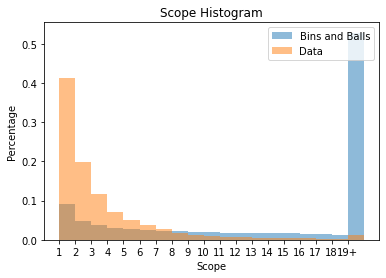

In [18]:
# Define custom bins
bins = list(range(1, 21))

# Calculate weights for dataframe column and numpy array
weights_df = np.ones_like(df_unique['nprod_b']) / len(df_unique['nprod_b'])
weights_array = np.ones_like(nprod_data) / len(nprod_data)

# Plotting the DataFrame column
plt.hist(df_unique['nprod_b'], bins=bins, alpha=0.5, label='Bins and Balls', weights=weights_df)

# Plotting the array
plt.hist(nprod_data, bins=bins, alpha=0.5, label='Data', weights=weights_array)

# Setting custom x-axis ticks and labels
tick_positions = list(range(1, 20))
tick_labels = [str(i) for i in range(1, 19)] + ['19+']
plt.xticks(tick_positions, tick_labels)

# Adding title and labels
plt.title('Scope Histogram')
plt.xlabel('Scope')
plt.ylabel('Percentage')
plt.legend(loc='upper right')  # To display a legend on the top right

# Save the plot to a PDF file
path = r'..\Includes-python'
plt.savefig(path+'\AppendixFig12.pdf', format='pdf')

# Display the plot
plt.show()
